Before we can optimize anything, we first need to extra the target data from a simulation.

In [64]:
import os as os
import sys as sys
import glob as glob
import math as math
import numpy as np
import scipy as sc
import subprocess as subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy import genfromtxt
from scipy import stats
from functools import reduce

import pytraj as pt

In [65]:
%matplotlib inline

In [118]:
simulation_directory = 'sample-data/pure-ethanol/'
parameter_file       = 'full.topo'
trajectory_files     = 'traj.001'
dt                   = 10.0  # picoseconds (dt = 0.002 * 5000 steps/frame)

In [119]:
traj = pt.iterload(simulation_directory+trajectory_files, simulation_directory+parameter_file)

In [120]:
volumes = pt.volume(traj)

In [134]:
diffusion = pt.diffusion(traj, tstep=dt, dtype='dict')

In [135]:
pt.diffusion(traj, tstep=dt, dtype='dict')

OrderedDict([('X',
              array([   0.        ,    5.22245717,    8.87997824, ...,  267.18243771,
                      272.35659023,  275.83195195])),
             ('Y',
              array([   0.        ,    4.94090717,    8.46863978, ...,  265.06787995,
                      268.20348172,  270.39236137])),
             ('Z',
              array([   0.        ,    4.88053531,    7.59024219, ...,  249.77583838,
                      249.9293094 ,  251.52116686])),
             ('R',
              array([   0.        ,   15.04389965,   24.93886021, ...,  782.02615604,
                      790.48938135,  797.74548017])),
             ('A',
              array([  0.        ,   3.87864663,   4.99388228, ...,  27.96473057,
                      28.115643  ,  28.24438847])),
             ('D',
              array([ 1.3031064 ,  1.3376192 ,  1.31758648,  1.25411351])),
             ('Label', array(['df_AvgDr', 'df_AvgDx', 'df_AvgDy', 'df_AvgDz'], 
                    dtype='<U8')),
 

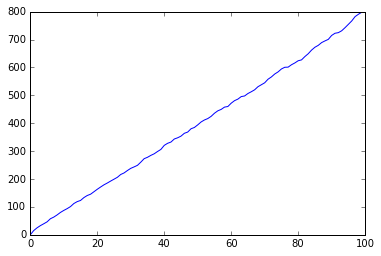

In [122]:
plt.plot(range(traj.n_frames), diffusion['R'])

In [129]:
diffusion['Slope'][0]

0.78186383809593174

In [130]:
text = '''
parm full.topo
trajin traj.001
unwrap
diffusion average 10
'''

In [131]:
state = pt.load_cpptraj_state(text, traj)

In [132]:
state.run()

CpptrajState, include:
<datasetlist: 11 datasets>

In [133]:
state.data['average[Slope]']

<pytraj.datasets.DatasetDouble: size=4, key=average[Slope]> 
values: 
[ 7.82269302  2.67437375  2.63676286  2.51155641]

# Blocking

In [58]:
trajectory = np.genfromtxt('sample-data/pure-opc/series-0.dat')

In [62]:
# trajectory = np.random.random(size=10)

def factorize(n):    
    return sorted(list(set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))))

[1, 2, 4, 5, 10, 20, 25, 50, 100, 125, 250, 500]
[1, 2, 4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 125, 160, 200, 250, 400, 500, 625, 800, 1000, 1250, 2000, 2500, 3125, 4000, 5000, 6250, 10000, 12500, 15625, 20000, 25000, 31250, 50000, 62500, 100000, 125000, 250000, 500000]


In [117]:
def blocking_analysis(blocks, trajectory):
    mean_for_each_block_size = np.empty((len(blocks)))
    sem_for_each_block_size = np.empty((len(blocks)))
    sem_error_for_each_block_size = np.empty((len(blocks)))
    for block_size in blocks:
        number_measurements = math.floor(len(trajectory) / block_size)
        # Loop over all blocks of the same size...
        mean_for_each_block = np.empty((number_measurements))
        for block in range(number_measurements):
            mean_for_each_block[block] = np.mean(trajectory[block * block_size: block * block_size + block_size])

        # mean_for_each_block_size[blocks.index(block_size)] = np.mean(mean_for_each_block)
        sem_for_each_block_size[blocks.index(block_size)] = stats.sem(mean_for_each_block)
        sem_error_for_each_block_size[blocks.index(block_size)] = sem_for_each_block_size[blocks.index(block_size)] / np.sqrt(2 * (number_measurements - 1))
    return sem_for_each_block_size, sem_error_for_each_block_size

In [ ]:
blocks = factorize(len(trajectory))
sem, sem_error = blocking_analysis(blocks, trajectory)

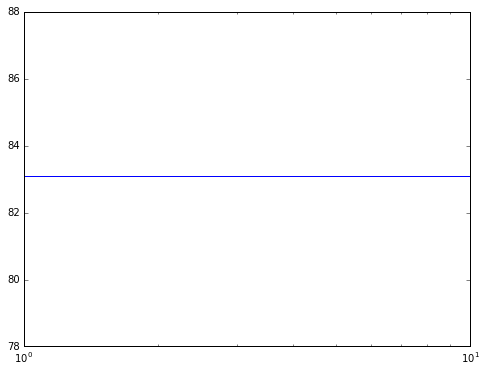

In [57]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
# ax1.errorbar(block_sizes, block_averages, yerr=block_sems)
ax1.errorbar(block_sizes, block_averages)
ax1.set_xscale('log')
y_formatter = mpl.ticker.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)

# Parmed inside optimization loop...

# Let's test with `mdtraj`

In [26]:
import mdtraj as md

In [30]:
trajectory = md.load_netcdf(simulation_directory+trajectory_files, top=simulation_directory+'full.prmtop')

In [31]:
trajectory

<mdtraj.Trajectory with 100 frames, 9000 atoms, 1000 residues, and unitcells at 0x7f17c49078d0>

In [33]:
md.isothermal_compressability_kappa_T(trajectory, 300)

9.016185464312506e-05

In [36]:
print(np.mean(md.density(trajectory)))
print(stats.sem(md.density(trajectory)))


788.045
0.489128446579


In [37]:
trajectory.select('water')

AttributeError: 'Trajectory' object has no attribute 'select'

In [ ]:
experimental = dict()
residues_names = ['eth', 'mth']
for residue_name in residues_names:
    if residue_name not in experimental:
        experimental[residue_name] = {}
    experimental[residue_name]['density'] = 2.0